# Classifieurs connus - AlexNet

## Objectif
L'objectif de ce notebook est de tester l'architecture de CNN AlexNet sur le jeu de données de l'étude.

## Présentation de AlexNet

![image](https://pub.mdpi-res.com/remotesensing/remotesensing-09-00848/article_deploy/html/images/remotesensing-09-00848-g001.png?1569499335)

AlexNet est un modèle de réseau de neurones convolutionnels (CNN) qui a remporté le concours ImageNet en 2012. Il est principalement utilisé pour la classification d'images. AlexNet a été conçu pour résoudre le problème de la classification d'images en utilisant une architecture profonde et une méthode d'entraînement efficace.

L'architecture d'AlexNet se compose de huit couches de neurones, dont cinq sont des couches de convolution, deux sont des couches de sous-échantillonnage (pooling) et une est une couche entièrement connectée. Il utilise également des couches de normalisation locale et une technique appelée "dropout" pour améliorer la généralisation du modèle.

AlexNet fonctionne en prenant une image en entrée, qui est ensuite passée dans les couches de convolution et de sous-échantillonnage pour extraire des caractéristiques de l'image. Ces caractéristiques sont ensuite utilisées pour classer l'image dans une catégorie donnée en utilisant la couche entièrement connectée.

AlexNet a été utilisé dans de nombreux domaines, notamment la reconnaissance d'objets, la reconnaissance faciale, la détection de maladies et la surveillance de la circulation routière. Il a également ouvert la voie à des réseaux de neurones convolutionnels plus profonds et plus complexes qui ont depuis été développés pour de nombreux cas d'utilisation différents.

## Hypothèses
Les hypothèses quant aux résultats attendus sont les suivants :
- Une précision équivalente à celle du CNN du template, étant donné les résultats avec ResNet50
- Un temps d'entraînement équivalent à celui du CNN

## Etapes de la démarche
1. Remplacer la méthode create_model() en implémentant l'architecture de AlexNet
2. Tester le modèle sur le jeu de données
3. Calculer les métriques de performance
4. Comparer les résultats avec les résultats du CNN

## Notes sur l'implémentation
Ayant rencontré des problèmes de mémoire lors de l'entrainement, les changements suivants ont été apportés :
- Le batch size a été réduit de 100 à 64
- La taille des images générées a été réduite de 256x256 à 128x128

## Conclusion
Les résultats obtenus sont les suivants :
- Une précision globale de 0.83, soit une précision largement inférieure à celle du CNN du template (0.92)
- Un temps d'entraînement plus rapide que le CNN du template (20ms/step contre 150ms/step). Cela peutêtre du au chanement de taille d'image, c'est pourquoi l'observation n'est pas la plus pertinente
- Des scores inconsistants entre les folds de validation

Malgré une précision acceptable avec une tendance à obtenir plus de faux négatifs que de faux positifs, le modèle n'est pas le plus optimal. Il est possible que l'architecture de AlexNet ne soit pas adaptée à ce jeu de données, ou que les paramètres d'entraînement ne soient pas optimaux.

In [1]:
# Check that GPU is used
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from PIL import Image
import os
import numpy as np

# Define the folders where your data is stored
train_folder = 'train'
test_folder = 'test'
val_folder = 'val'

# Define the subfolders within each folder where the images are stored
subfolders = ['NORMAL', 'PNEUMONIA']

# Define the size of the images you want to resize your images to
img_width, img_height = 128, 128 # Function to load and resize images from a folder

In [3]:
# Function to load and resize images from a folder
def load_images_from_folder(folder, limit_per_subfolder=None):
    X = []
    y = []
    for subfolder in subfolders:
        folder_path = os.path.join(folder, subfolder)
        if limit_per_subfolder:
            # Get amount of random filenames from the folder
            filenames = np.random.choice(os.listdir(folder_path), limit_per_subfolder, replace=False)
        else:
            filenames = os.listdir(folder_path)
        for filename in filenames:
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)

            # Resize the image to the desired size
            img = img.resize((img_width, img_height))

            # Convert RGB image to grayscale
            img = img.convert('L')

            # Convert the image to a NumPy array and append it to X
            img = np.array(img)
            X.append(img)

            # Append the corresponding label to y
            y.append(subfolders.index(subfolder))

    X = np.array(X)
    y = np.array(y)
    return X, y

In [4]:
# Generate augmented for the training set
from common.data_augmentation import generate_augmented_images
generate_augmented_images(train_folder, 'NORMAL', image_size=(img_width, img_height))
generate_augmented_images(train_folder, 'PNEUMONIA', image_size=(img_width, img_height))

Found 1341 images belonging to 1 classes.
Additional count of images to generate: 0
Given NORMAL count: 1341
Augmented NORMAL count: 5000
Found 3874 images belonging to 1 classes.
Additional count of images to generate: 0
Given PNEUMONIA count: 3874
Augmented PNEUMONIA count: 5000


In [5]:
# Load the training data
# Get min value between the number of normal images and the number of pneumonia images
train_folder = f"{train_folder}_augmented"
min_images = min(len(os.listdir(os.path.join(train_folder, subfolders[0]))), len(os.listdir(os.path.join(train_folder, subfolders[1]))))
X_train, y_train = load_images_from_folder(train_folder, min_images)

# Load the test data
X_test, y_test = load_images_from_folder(test_folder)

# Load the validation data
X_val, y_val = load_images_from_folder(val_folder)

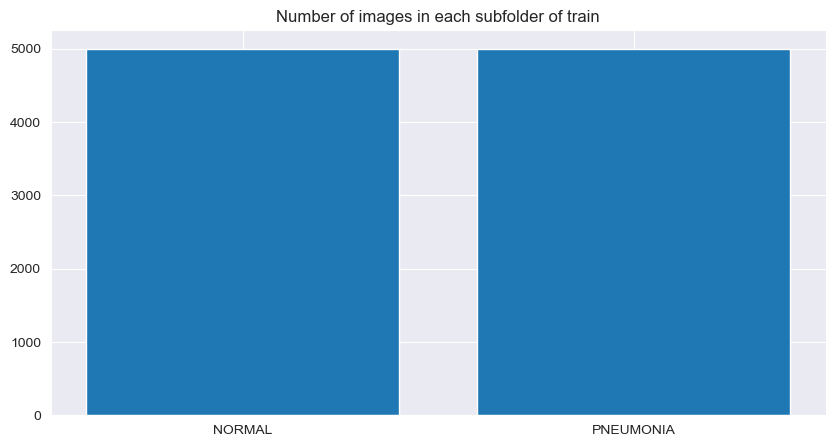

In [6]:
# Make a matplot figure to show how many images are in each subfolder of train
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(subfolders, [len(os.listdir(os.path.join(train_folder, subfolder))) for subfolder in subfolders])
plt.title('Number of images in each subfolder of train')
plt.show()

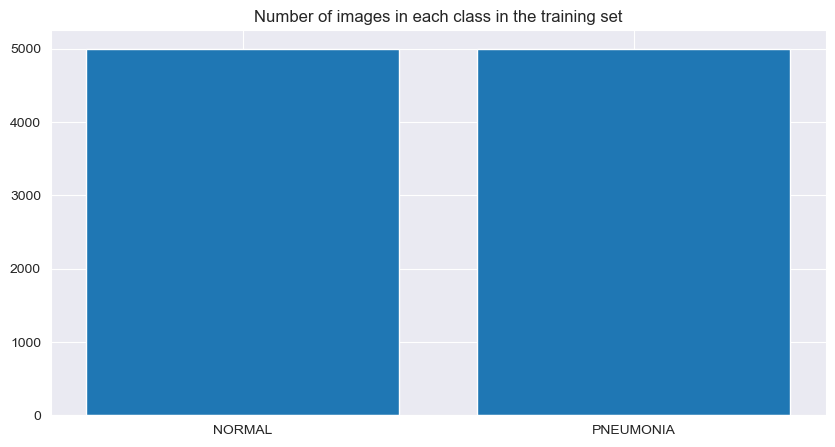

In [7]:
# Make a matplot figure to show how many images if each class in the training set
plt.figure(figsize=(10, 5))
plt.bar(subfolders, [len(y_train[y_train == i]) for i in range(len(subfolders))])
plt.title('Number of images in each class in the training set')
plt.show()

In [8]:
# Normalize the pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_val = X_val.astype('float32') / 255

X_train = X_train.reshape(len(X_train), img_width, img_height)
X_test = X_test.reshape(len(X_test), img_width, img_height)
X_val = X_val.reshape(len(X_val), img_width, img_height)

# Add two channels to make the images RGB
X_train = np.repeat(X_train[..., np.newaxis], 3, -1)
X_test = np.repeat(X_test[..., np.newaxis], 3, -1)
X_val = np.repeat(X_val[..., np.newaxis], 3, -1)

(128, 128, 3)


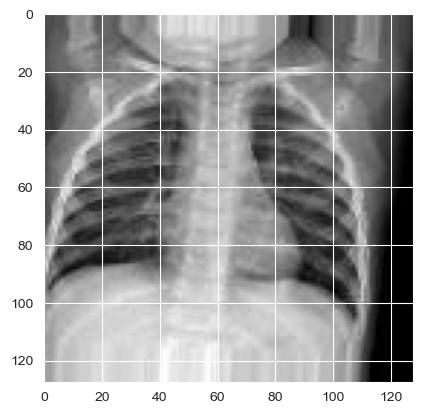

In [9]:
single_image = X_train[np.random.randint(len(X_train))]
print(single_image.shape)
plt.imshow(single_image, cmap='Greys')

In [10]:
# Define model metrics
from keras.metrics import AUC

metrics = [
    "accuracy",
    AUC(name='auc')
]

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model architecture
def create_model():
    #Instantiate an empty model
    model = Sequential()
    
    # 1st Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=(img_width, img_height, 3), kernel_size=(11,11), strides=(4,4), padding='same', activation='relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    
    # 2nd Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid', activation='relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    
    # 3rd Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
    
    # 4th Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
    
    # 5th Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    
    # Passing it to a Fully Connected layer
    model.add(Flatten())
    # 1st Fully Connected Layer
    model.add(Dense(4096, input_shape=(img_width * img_height * 3,), activation='relu'))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.4))
    
    # 2nd Fully Connected Layer
    model.add(Dense(4096, activation='relu'))
    # Add Dropout
    model.add(Dropout(0.4))
    
    # 3rd Fully Connected Layer
    model.add(Dense(1000, activation='relu'))
    # Add Dropout
    model.add(Dropout(0.4))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
    
    return model

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

In [13]:
# Cross validation
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator

# Define the number of folds for cross-validation
n_splits = 10
epochs = 7
batch_size = 64

# Initialize KFold with the number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define lists to store the evaluation scores for each fold
accuracy_scores = []
histories = []
models = []

# Iterate through each fold and train/evaluate the model
for train_idx, val_idx in kf.split(X_train, y_train):
    # Split the data into training and validation sets for this fold
    X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

    # Create an instance of ImageDataGenerator to generate your image data
    datagen = ImageDataGenerator()

    # Create generators for training and validation data
    train_generator = datagen.flow(x=X_train_fold, y=y_train_fold, batch_size=batch_size)
    valid_generator = datagen.flow(x=X_val_fold, y=y_val_fold, batch_size=batch_size)

    # Create instance of the model for this fold and train it
    model = create_model()

    # Train your model on the training data for this fold
    history = model.fit(train_generator, validation_data=valid_generator, epochs=epochs, verbose=1, callbacks=[early_stop])
    histories.append(history.history)

    models.append(model)


Epoch 1/7
141/141 [==============================] - 9s 33ms/step - loss: 0.6956 - accuracy: 0.4962 - auc: 0.4935 - val_loss: 0.6938 - val_accuracy: 0.4920 - val_auc: 0.5000
Epoch 2/7
141/141 [==============================] - 4s 29ms/step - loss: 0.6933 - accuracy: 0.5032 - auc: 0.5005 - val_loss: 0.6934 - val_accuracy: 0.4920 - val_auc: 0.5000
Epoch 3/7
141/141 [==============================] - 4s 29ms/step - loss: 0.6933 - accuracy: 0.4992 - auc: 0.4969 - val_loss: 0.6932 - val_accuracy: 0.4920 - val_auc: 0.5000
Epoch 4/7
141/141 [==============================] - 4s 28ms/step - loss: 0.6933 - accuracy: 0.4979 - auc: 0.4946 - val_loss: 0.6934 - val_accuracy: 0.4920 - val_auc: 0.5000
Epoch 5/7
141/141 [==============================] - 4s 29ms/step - loss: 0.6931 - accuracy: 0.5067 - auc: 0.4972 - val_loss: 0.6931 - val_accuracy: 0.4920 - val_auc: 0.5000
Epoch 6/7
141/141 [==============================] - 4s 28ms/step - loss: 0.6932 - accuracy: 0.5019 - auc: 0.4962 - val_loss: 0.69

In [14]:
# Get accuracy scores for each fold (train and validation)
loss = []
acc = []
val_loss = []
val_acc = []

for history in histories:
    loss.append(np.mean(history["loss"]))
    acc.append(np.mean(history["accuracy"]))
    val_loss.append(np.mean(history["val_loss"]))
    val_acc.append(np.mean(history["val_accuracy"]))

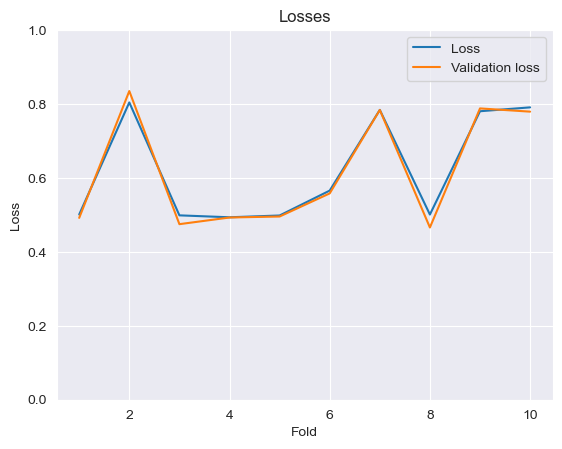

In [15]:
# Plot loss and validation loss per fold
import matplotlib.pyplot as plt
plt.title('Losses')
plt.plot(range(1, len(acc)+1), acc, label='Loss')
plt.plot(range(1, len(val_acc)+1), val_acc, label='Validation loss')
plt.ylim(0.0, 1.0)
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()
plt.show()

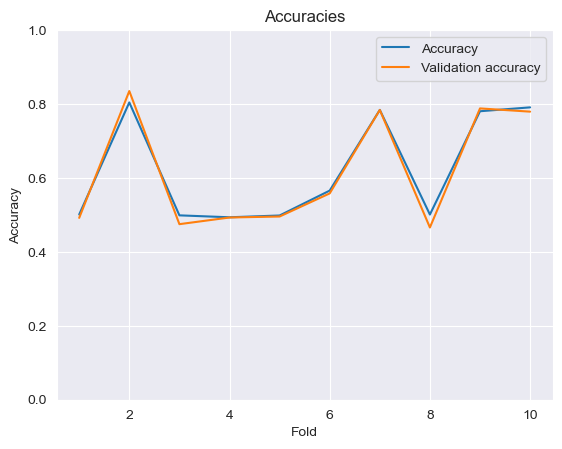

In [16]:
# Plot accuracies and validation accuracies per fold
import matplotlib.pyplot as plt
plt.title('Accuracies')
plt.plot(range(1, len(acc)+1), acc, label='Accuracy')
plt.plot(range(1, len(val_acc)+1), val_acc, label='Validation accuracy')
plt.ylim(0.0, 1.0)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

On remarque une inconsistance dans les résultats de la cross validation. On va donc entrainer un modèle sur l'ensemble des données d'entrainement et le sauvegarder pour voir si cette inconsistence se ressent aussi dans l'entrainement final. Cette inconsistence peut être due à la taille de l'ensemble de données d'entrainement qui est assez petit ou bien à l'architecture du modèle, mais ce phénomène n'est pas observable sur l'entrainement sur notre CNN customisé ni sur l'implémentation de ResNet50.

In [17]:
# Train a final model with same parameters and save it
train_generator = datagen.flow(x=X_train, y=y_train, batch_size=batch_size)
valid_generator = datagen.flow(x=X_val, y=y_val, batch_size=batch_size)
model = create_model()
history = model.fit(train_generator, validation_data=valid_generator, epochs=epochs, verbose=1, callbacks=[early_stop])
model.save('alexnet.h5')

Epoch 1/7
157/157 [==============================] - 5s 31ms/step - loss: 0.6702 - accuracy: 0.5629 - auc: 0.6504 - val_loss: 0.6793 - val_accuracy: 0.6250 - val_auc: 0.8281
Epoch 2/7
157/157 [==============================] - 4s 28ms/step - loss: 0.4955 - accuracy: 0.7759 - auc: 0.8397 - val_loss: 0.7938 - val_accuracy: 0.6875 - val_auc: 0.8750
Epoch 3/7
157/157 [==============================] - 4s 28ms/step - loss: 0.4103 - accuracy: 0.8269 - auc: 0.8965 - val_loss: 0.4555 - val_accuracy: 0.7500 - val_auc: 0.9219
Epoch 4/7
157/157 [==============================] - 5s 29ms/step - loss: 0.3671 - accuracy: 0.8448 - auc: 0.9171 - val_loss: 0.3628 - val_accuracy: 0.8750 - val_auc: 0.9062
Epoch 5/7
157/157 [==============================] - 4s 28ms/step - loss: 0.2969 - accuracy: 0.8786 - auc: 0.9455 - val_loss: 0.2216 - val_accuracy: 0.9375 - val_auc: 1.0000
Epoch 6/7
157/157 [==============================] - 4s 28ms/step - loss: 0.2367 - accuracy: 0.9055 - auc: 0.9655 - val_loss: 0.28

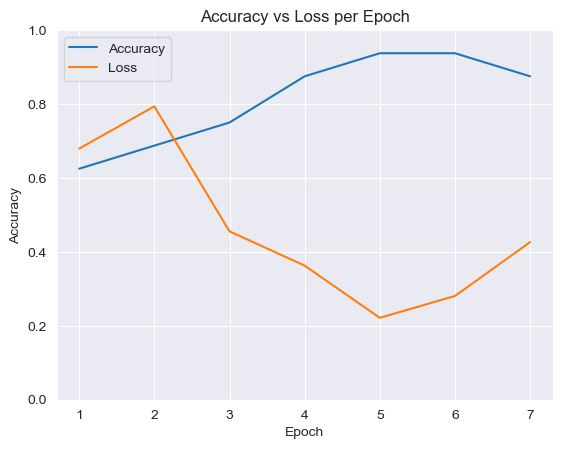

In [18]:
# Plot val accuracy and val loss of the trained model
import matplotlib.pyplot as plt
plt.title('Accuracy vs Loss per Epoch')
plt.plot(range(1, len(history.history["val_accuracy"])+1), history.history["val_accuracy"], label='Accuracy')
plt.plot(range(1, len(history.history["val_loss"])+1), history.history["val_loss"], label='Loss')
plt.ylim(0.0, 1.0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
# Make predictions on the test set
y_pred_test = model.predict(X_test)
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0)

20/20 [==============================] - 0s 3ms/step


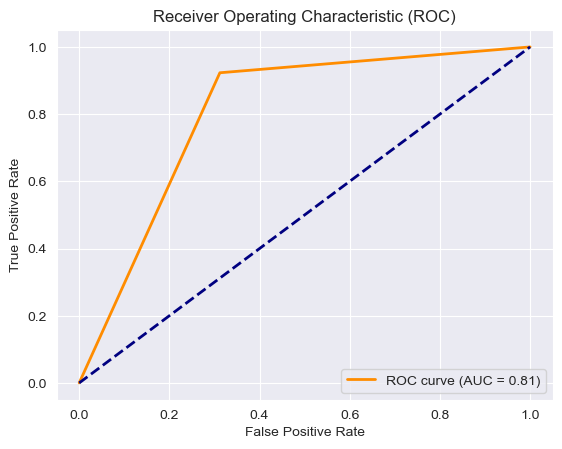

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC score for the predictions
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve and show AUC score on the plot
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [21]:
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test.flatten())
print(cm)

[[161  73]
 [ 30 360]]


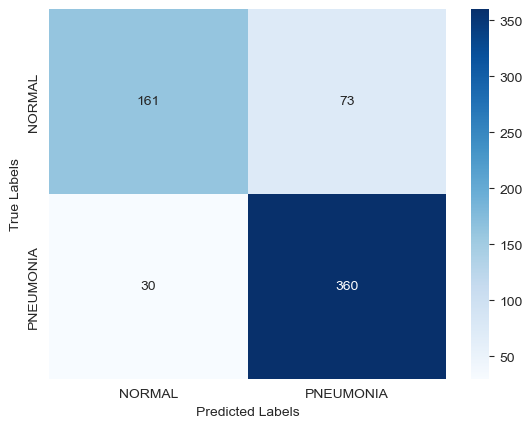

In [22]:
# Plot the confusion matrix
class_names = subfolders
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

On observe un plus grand nombre de faux négatifs que de faux positifs, ce qui est plutôt positif dans le cadre de la détection de la pneumonie.

In [23]:
# Compute the classification report for test set
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test, target_names=class_names))

              precision    recall  f1-score   support

      NORMAL       0.84      0.69      0.76       234
   PNEUMONIA       0.83      0.92      0.87       390

    accuracy                           0.83       624
   macro avg       0.84      0.81      0.82       624
weighted avg       0.84      0.83      0.83       624



La précision est plutôt bonne pour les deux classes, mais le rappel est plus faible pour la classe "Normal". Cela signifie que le modèle a tendance à prédire "Pneumonia" plus souvent que "Normal". De plus la précision est seulement de 83% au global, ce qui est relativement faible par rapport au résultat du template (0.92).

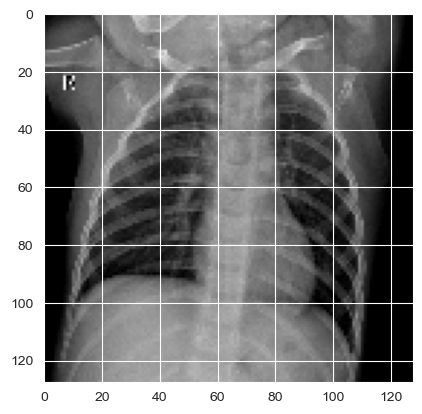

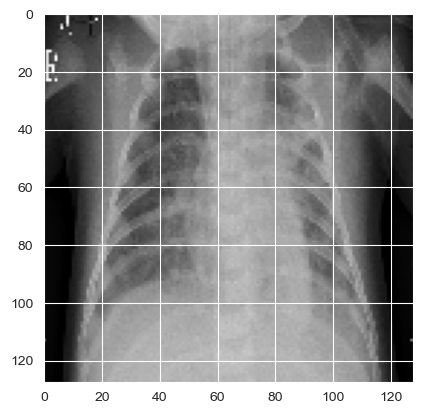

In [50]:
# Heatmaps and Grad-CAM
from common.cam import get_img_array
import cv2
import matplotlib.pyplot as plt 

images = [
    {
        "path": "./val/NORMAL/NORMAL2-IM-1442-0001.jpeg"
    },
    {
        "path": "./val/PNEUMONIA/person1946_bacteria_4874.jpeg"
    }
]

for image in images:
    image_temp = cv2.imread(image["path"])
    image_temp = cv2.cvtColor(image_temp, cv2.COLOR_RGB2GRAY)
    image_temp = cv2.resize(image_temp, (img_width, img_height))

    plt.imshow(image_temp, cmap=plt.cm.gray)
    plt.show()

    image["array"] = get_img_array(image["path"], size=(img_width, img_height), grayscale=False)

In [51]:
# Remove last layer's softmax
model.layers[-1].activation = None

# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [52]:
# Print model summary to get last max pooling layer name
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 32, 32, 96)        34944     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 16, 16, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 6, 6, 256)         2973952   
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 3, 3, 256)        0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 3, 3, 384)         885120    
                                                                 
 conv2d_53 (Conv2D)          (None, 3, 3, 384)       

In [53]:
# Select last conv layer
last_conv_layer_name = "conv2d_54"

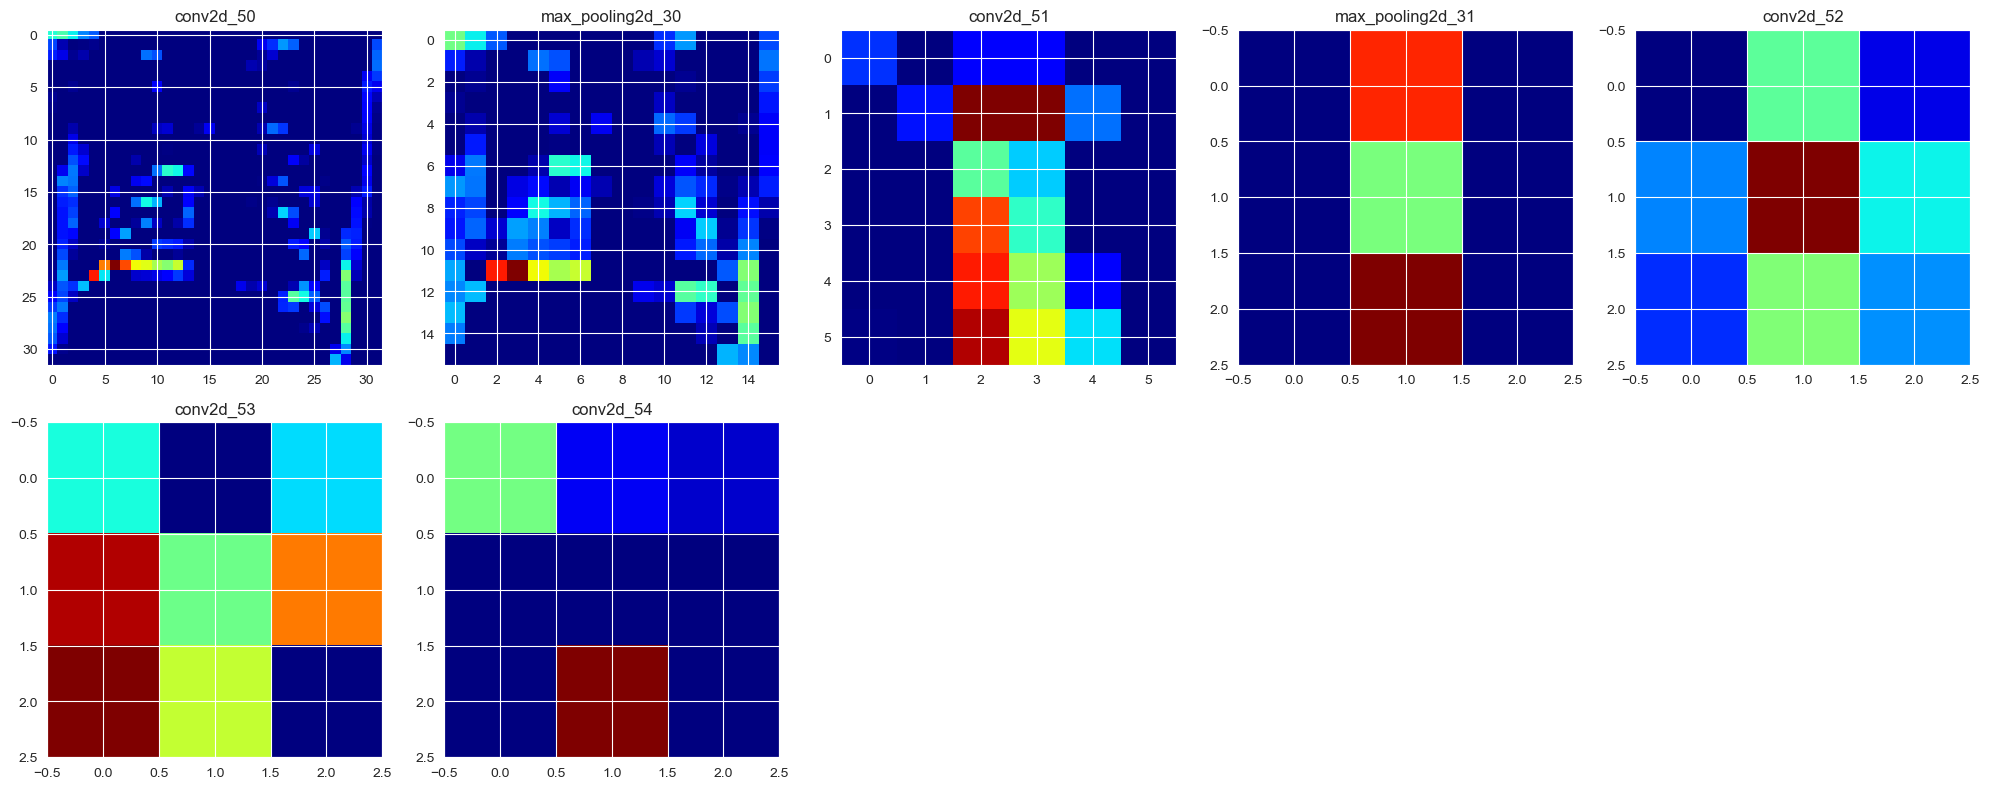

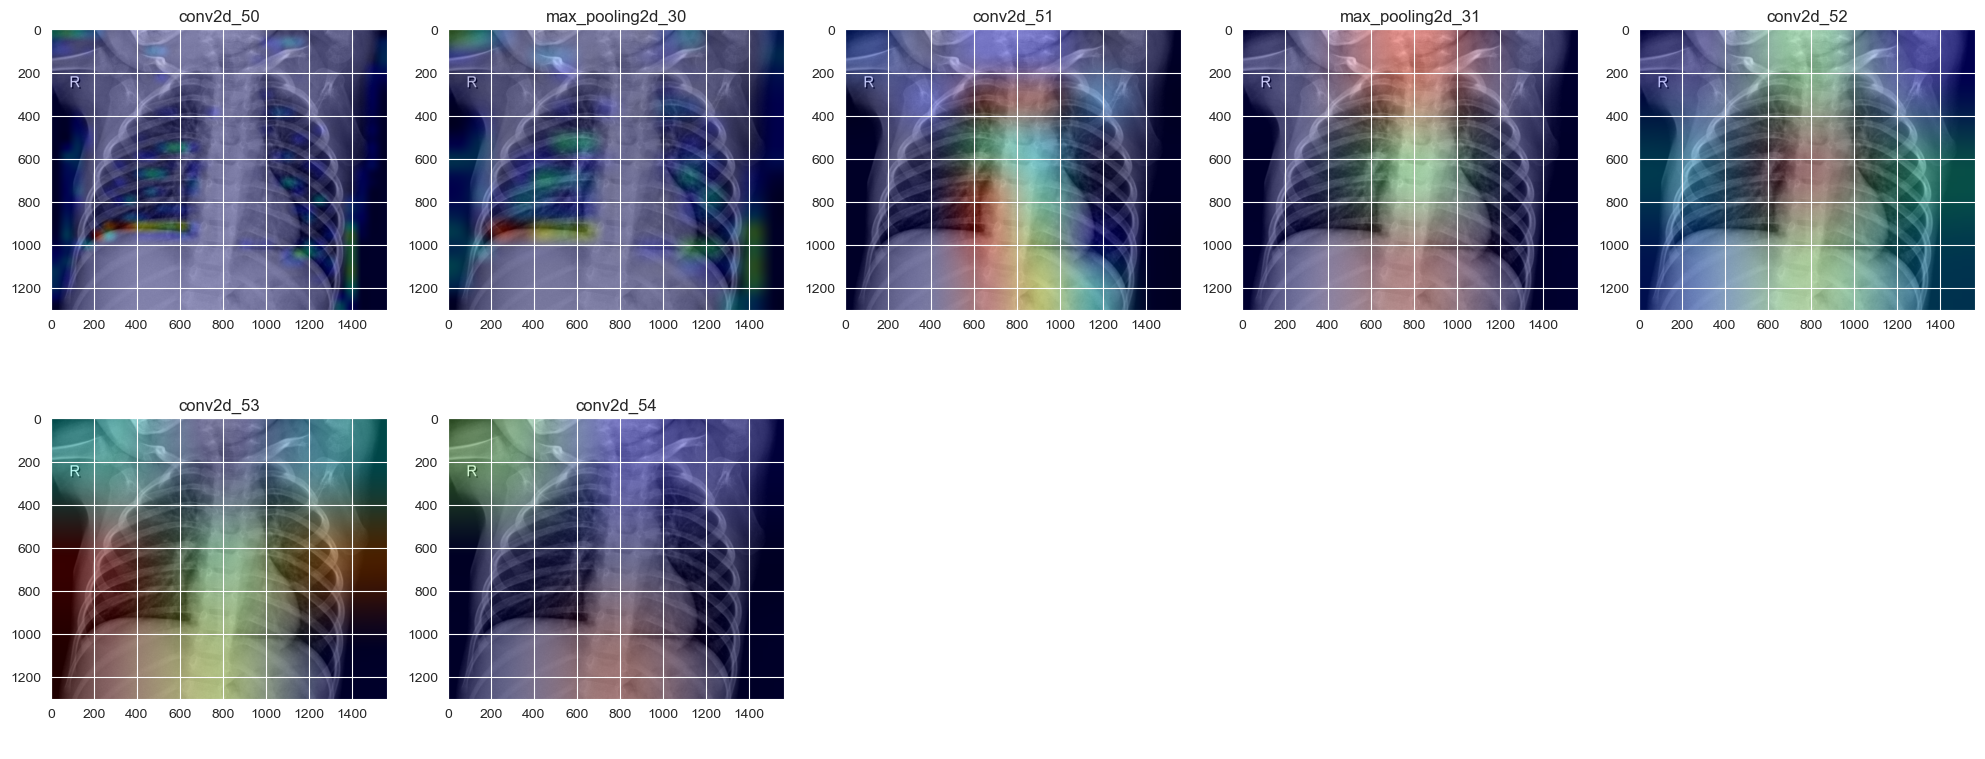

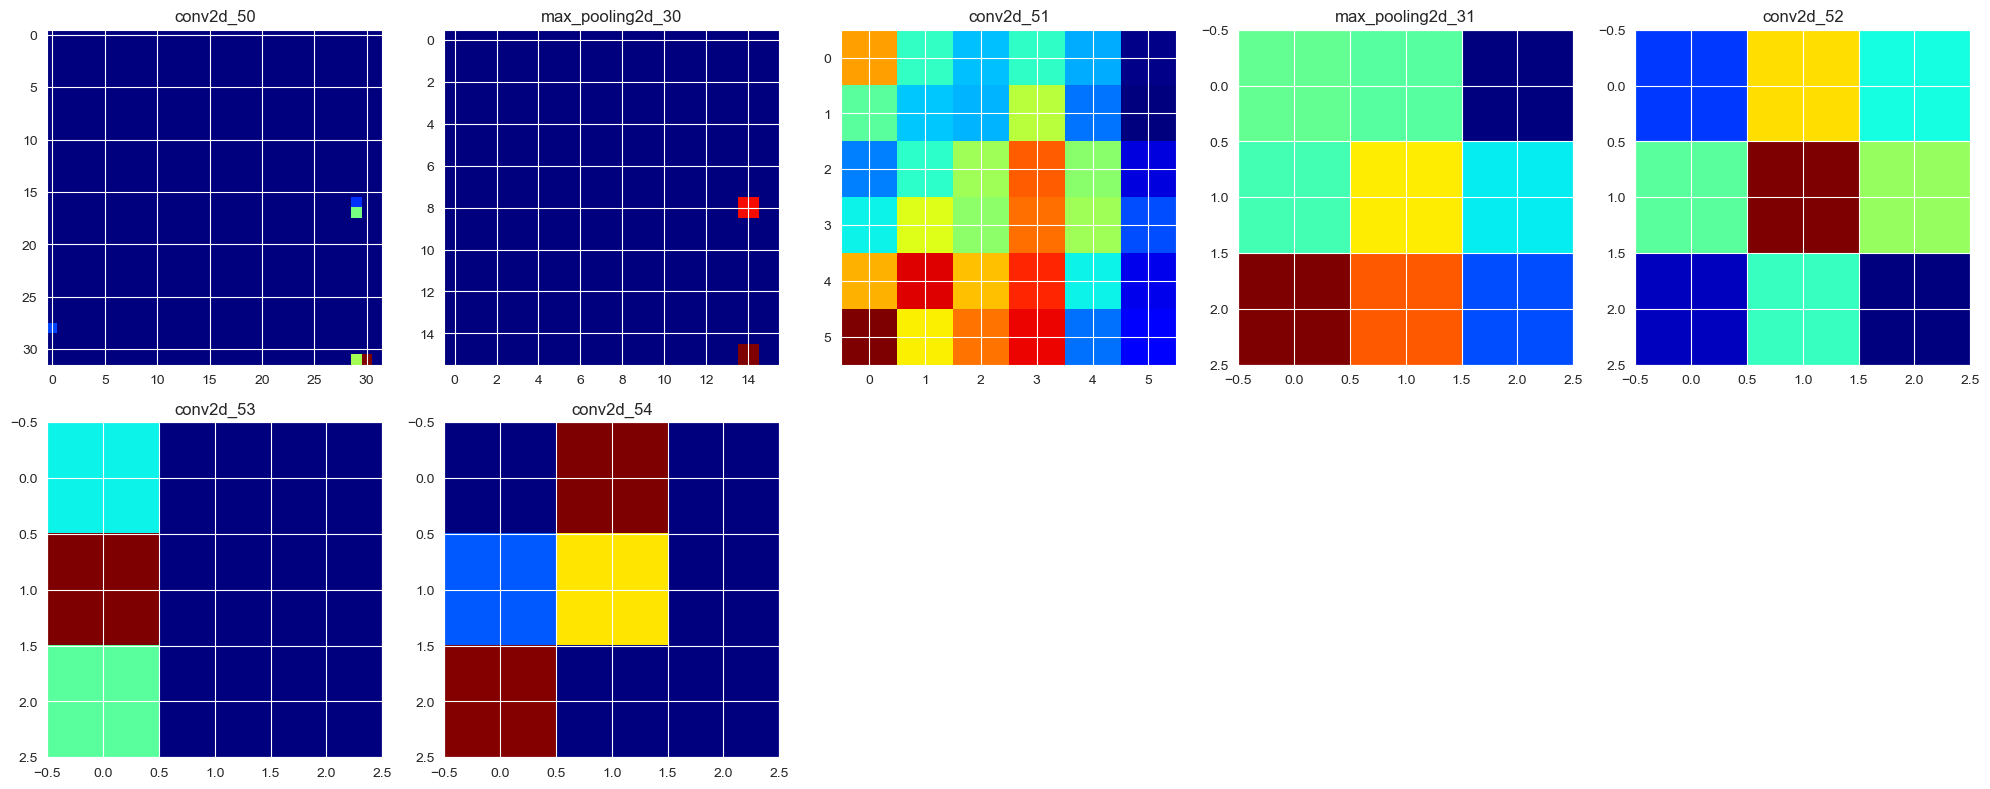

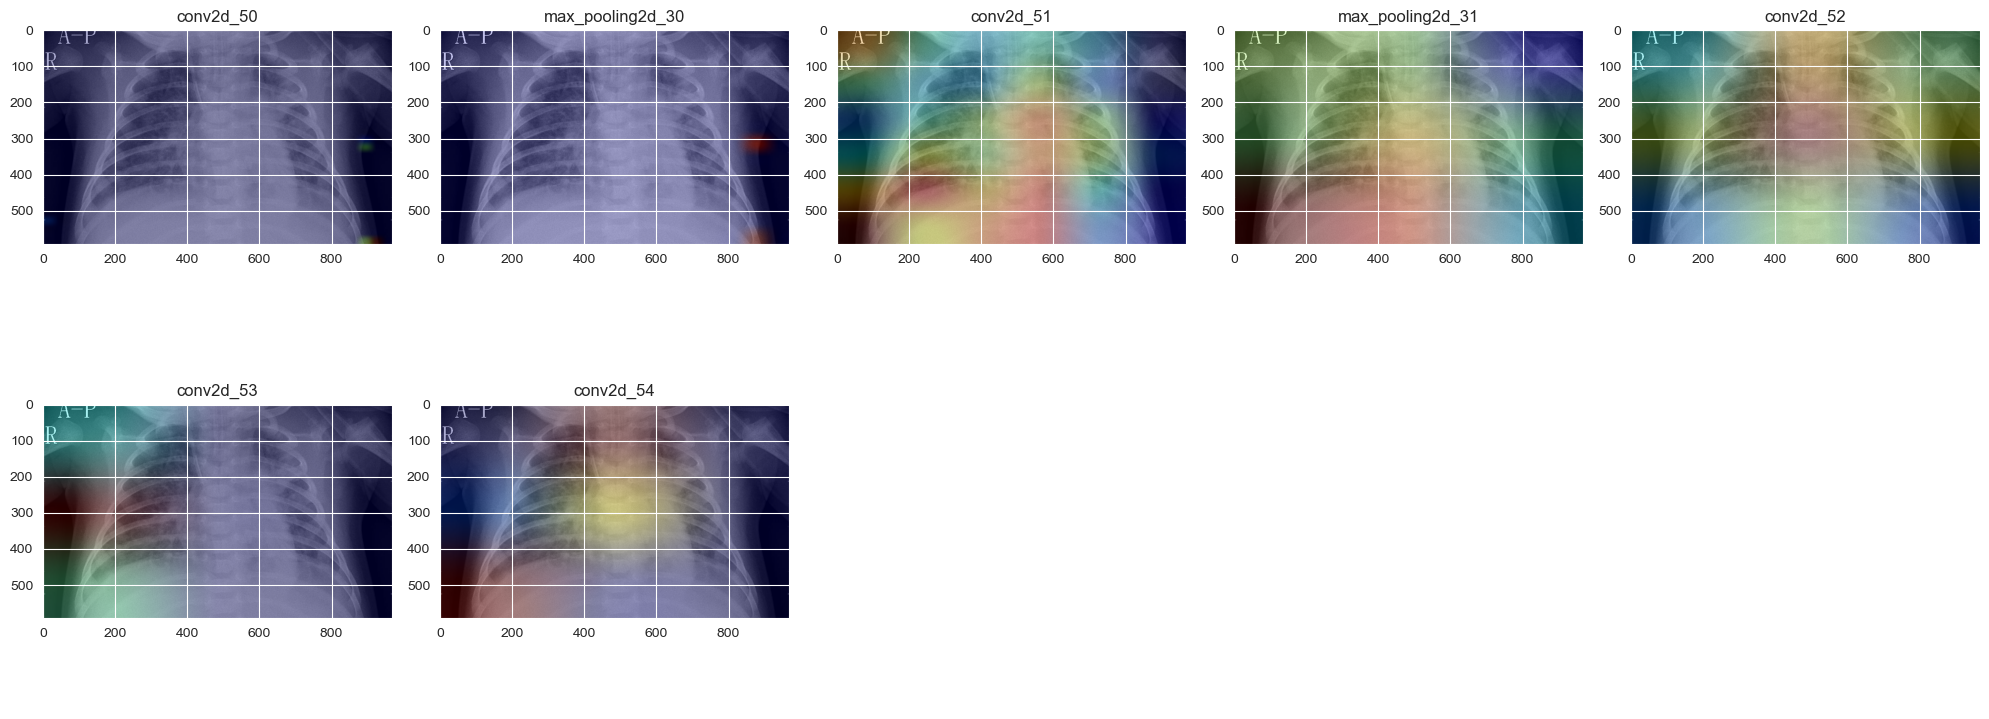

In [54]:
from common.cam import make_gradcam_heatmap, display_heatmaps

for image in images:
    heatmaps = []
    for layer in model.layers[:model.layers.index(model.get_layer(last_conv_layer_name)) + 1]:
        heatmap = make_gradcam_heatmap(image["array"], model, layer.name)
        heatmaps.append({
            "layer_name": layer.name,
            "image": heatmap
        })

    # Display heatmaps from all layers until the last max pooling layer
    display_heatmaps(image["path"], heatmaps)

    # Display the chosen image superimposed with heatmaps of each layer until the last max pooling layer
    display_heatmaps(image["path"], heatmaps, True)

In [55]:
# Predict
for image in images:
    pred = model.predict(image["array"].reshape(1, img_width, img_height, 3))
    print(pred)
    # Display predicted class
    print("Predicted class: {}".format(subfolders[int(pred[0][0])]))

1/1 [==============================] - 0s 13ms/step
[[0.]]
Predicted class: NORMAL
1/1 [==============================] - 0s 12ms/step
[[1.]]
Predicted class: PNEUMONIA
